<h1>House Prices Advanced Regression Techniques</h1><br>

**ID: AI-0007<br>
Submission date: 11-1-2018**
<br><br>

The goal of this experiment is to determine house price from the given features. Here I have tried different algorithms including ANN which was the primary requirement to determine the optimal algorithm. To begin, let's import everything necessary for the project.

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew 
from sklearn.linear_model import Lasso, LassoCV, Ridge, ElasticNetCV, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, Imputer,RobustScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.image as mpimg
#import warnings
#warnings.filterwarnings('ignore')


Before getting into the dataset, here I have built some some functions that will come handy while solving the problem. Thus, eliminating writing the same code again and again.

In [3]:
#find optimal features for a regration problem
def optimal_features(x,y):
    clf_lr = LinearRegression() 
    rfecv = RFECV(estimator=clf_lr, step=1, cv=10)
    rfecv = rfecv.fit(x, y)

    print('Optimal number of features :', rfecv.n_features_)
    print('Best features :', x.columns[rfecv.support_])
    return list(x.columns[rfecv.support_])

In [4]:
# normalizing the data 
def normalize_data(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    print(X_scaled.shape)
    return X_scaled

In [5]:
def cross_val_score_calculation(clf,X,y):
    clf.fit(X, y)
    accuracys = cross_val_score(clf, X,y,cv = 5)
    print(accuracys)
    print(np.average(accuracys))
    return np.average(accuracys)

In [6]:
def create_result_csv(y,predictions_id):
    output = pd.DataFrame()
    output['ID'] = predictions_id
    output['SalePrice'] = y
    output.to_csv("test_y.csv", encoding='utf-8', index=False)

Now that some functions are created for ease of use, let's get into the dataset.

In [7]:
#importing the training dataset
data = pd.read_csv("train.csv")

at first, let's look into the correlation matrix to see which feature is related to which feature. So we can optimize the dataset

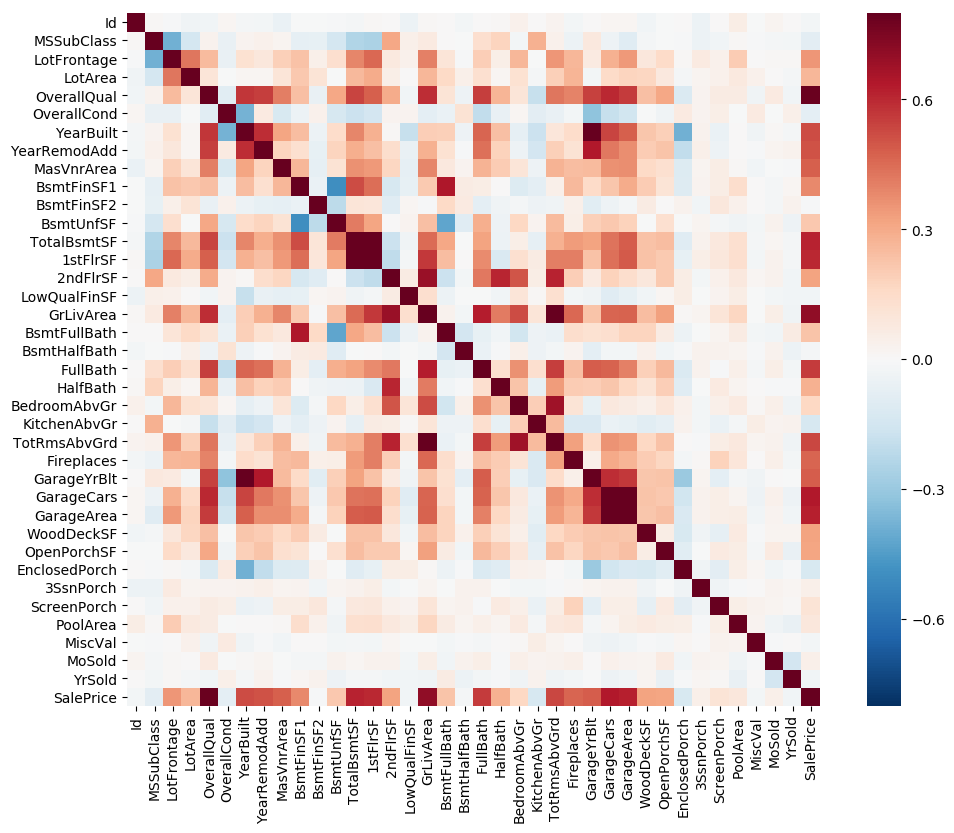

In [74]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

correlation matrix shows us there are several features whose co-relation value is greater then 0.5

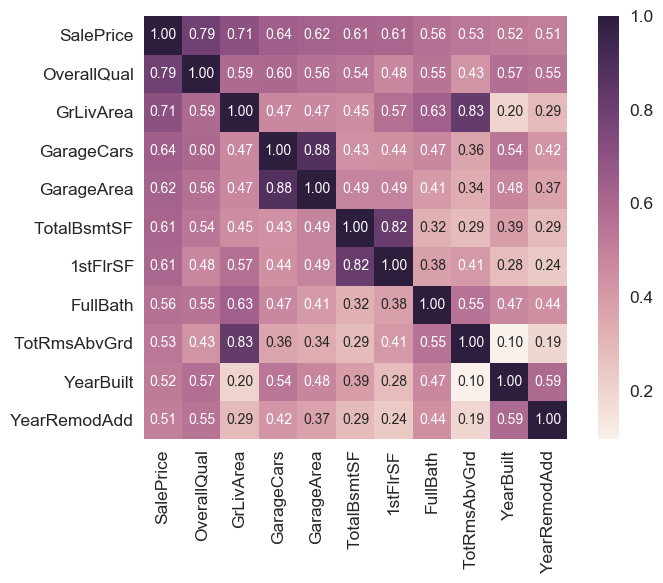

In [9]:
#saleprice correlation matrix
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.absolute(np.corrcoef(data[cols].values.T))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

now check, if there is any missing value in the features selected from the above heatmap

In [10]:
data[['SalePrice', 'YearBuilt', 'OverallQual', 'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'FullBath','GarageArea','1stFlrSF','TotRmsAbvGrd','YearRemodAdd']].isnull().values.any()

False

so, there is no missing value.

now from some domain knowledge we know, Neighborhood (Physical locations within Ames city) is an importent feature. So I've added the neighborhood feature into the feature set. And then I've removed the saleprice because this is the feature I'll be predicting.

In [11]:
feature = ['SalePrice','Neighborhood', 'YearBuilt', 'OverallQual', 'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'FullBath','GarageArea','1stFlrSF','TotRmsAbvGrd','YearRemodAdd']
new_data = data[feature]

In [12]:
y = data.SalePrice
drop_list = ["SalePrice"]
#len(y)

I've dropped the saleprice from X here and then used one-hot encoding to the features.

In [13]:
X = new_data.drop(drop_list,axis=1)
X = pd.get_dummies(X)

Now let,s try different algorithms. Starting with random forest

In [14]:
regrf_corelation = RandomForestRegressor(n_estimators = 150,max_depth = 10,min_samples_split = 5)
#regr = RandomForestRegressor(n_estimators = 150,max_depth = 25,min_samples_split = 10)

regrf_corelation_cv_score = cross_val_score_calculation(regrf_corelation,X, y)

[ 0.84563522  0.78249894  0.86977037  0.875469    0.82102965]
0.838880636739


This time, I've tried ANN without tuning any parameters to check the result at first

In [15]:
regrMLP_corelation = MLPRegressor(hidden_layer_sizes=(550),activation='relu', solver='adam',max_iter=800 )
#regrMLP = MLPRegressor(hidden_layer_sizes=(3500),activation='tanh', solver='lbfgs' )#0.883014653591

regrMLP_corelation_cv_score = cross_val_score_calculation(regrMLP_corelation,X,y)

[ 0.75355138  0.71479813  0.70036573  0.67016679  0.49871965]
0.667520337579


from the above two experiments, we can see that without major preprosseing, the accuracy is not that great. The neural network score is even worse than random forest. Since neural network is our primary focus, I'll be tuning the dataset to improve accuracy furthermore. This starts with preprossesing of the test data.

In [16]:
data_test = pd.read_csv("test.csv")

We'll need the Ids of the test dataset for our final submission, so we've dropped it from our test set but saved it in a different dataframe. The features for the test set are the ones that we got from the heatmap of the train set above.

In [17]:
test_feature = ['Id','Neighborhood' ,'YearBuilt', 'OverallQual', 'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'FullBath','GarageArea','1stFlrSF','TotRmsAbvGrd','YearRemodAdd']
x_test = data_test[test_feature]
drop_list = ["Id"]
ids = x_test.Id
x_test = x_test.drop(drop_list,axis=1)

Now, let's check for missing values and fill them

In [18]:
#missing value handeling
x_test['GarageCars']=x_test['GarageCars'].fillna(2)
x_test['FullBath']=x_test['FullBath'].fillna(np.mean(x_test['FullBath']))
x_test['TotalBsmtSF']=x_test['TotalBsmtSF'].fillna(np.mean(x_test['TotalBsmtSF']))
x_test['GarageArea']=x_test['GarageArea'].fillna(np.mean(x_test['GarageArea']))

Now, with the dataset prepared, let's run random forest once again to see the predictions

In [19]:
x_test = pd.get_dummies(x_test)

regrf_corelation.fit(X, y)
predict_y = regrf_corelation.predict(x_test)

In [20]:
create_result_csv(predict_y,ids)

this approch give me **0.1602** mean square in kaggle<br>

In [21]:
X.describe()

,YearBuilt,OverallQual,GarageCars,GrLivArea,TotalBsmtSF,FullBath,GarageArea,1stFlrSF,TotRmsAbvGrd,YearRemodAdd,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1971.267808,6.099315,1.767123,1515.463699,1057.429452,1.565068,472.980137,1162.626712,6.517808,1984.865753,...,0.028082,0.05274,0.077397,0.017123,0.050685,0.040411,0.058904,0.017123,0.026027,0.007534
std,30.202904,1.382997,0.747315,525.480383,438.705324,0.550916,213.804841,386.587738,1.625393,20.645407,...,0.165264,0.22359,0.267312,0.129775,0.219429,0.196989,0.235526,0.129775,0.159271,0.086502
min,1872.000000,1.000000,0.000000,334.000000,0.000000,0.000000,0.000000,334.000000,2.000000,1950.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1954.000000,5.000000,1.000000,1129.500000,795.750000,1.000000,334.500000,882.000000,5.000000,1967.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,6.000000,2.000000,1464.000000,991.500000,2.000000,480.000000,1087.000000,6.000000,1994.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2000.000000,7.000000,2.000000,1776.750000,1298.250000,2.000000,576.000000,1391.250000,7.000000,2004.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2010.000000,10.000000,4.000000,5642.000000,6110.000000,3.000000,1418.000000,4692.000000,14.000000,2010.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
x_test.describe()

,YearBuilt,OverallQual,GarageCars,GrLivArea,TotalBsmtSF,FullBath,GarageArea,1stFlrSF,TotRmsAbvGrd,YearRemodAdd,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,1971.357779,6.078821,1.766278,1486.045922,1046.117970,1.570939,472.768861,1156.534613,6.385195,1983.662783,...,0.020562,0.061001,0.086361,0.015764,0.052776,0.045236,0.065798,0.017820,0.023304,0.008910
std,30.390071,1.436812,0.775703,485.566099,442.746712,0.555190,216.974165,398.165820,1.508895,21.130467,...,0.141961,0.239414,0.280992,0.124605,0.223662,0.207894,0.248015,0.132344,0.150918,0.094005
min,1879.000000,1.000000,0.000000,407.000000,0.000000,0.000000,0.000000,407.000000,3.000000,1950.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1953.000000,5.000000,1.000000,1117.500000,784.000000,1.000000,318.000000,873.500000,5.000000,1963.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,6.000000,2.000000,1432.000000,988.000000,2.000000,480.000000,1079.000000,6.000000,1992.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2001.000000,7.000000,2.000000,1721.000000,1304.000000,2.000000,576.000000,1382.500000,7.000000,2004.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2010.000000,10.000000,5.000000,5095.000000,5095.000000,4.000000,1488.000000,5095.000000,15.000000,2010.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we see, not all features mean are not same. So normalizing data may increase cross validation score. 

In [23]:
normalized_X_train = normalize_data(X)

(1460, 35)


In [24]:
normalized_X_test = normalize_data(x_test)

(1459, 35)


In [25]:
regrf_corelation_normalize_cv_score = cross_val_score_calculation(regrf_corelation,normalized_X_train, y)

[ 0.84512503  0.79063967  0.8668444   0.87372201  0.83143425]
0.841553071897


In [26]:
regrMLP_co_norm = MLPRegressor(hidden_layer_sizes=(550),activation='relu', solver='adam',max_iter=15000 )
regrMLP_corelation_normalize_cv_score = cross_val_score_calculation(regrMLP_co_norm,normalized_X_train, y)

[ 0.87186353  0.88588697  0.87950778  0.87852327  0.76185133]
0.855526578192


From these, we can see that, after normalizing the dataset, the result for random forest decreased slightly. However, the accuarcy of the neural network increased significantly.(from 0.65~ to 0.85~)

In [27]:
regrMLP_co_norm.fit(normalized_X_train, y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=550, learning_rate='constant',
       learning_rate_init=0.001, max_iter=15000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [28]:
regrMLP_co_norm_pred_y = regrMLP_co_norm.predict(normalized_X_test)

In [29]:
create_result_csv(regrMLP_co_norm_pred_y,ids)

As the requirement is using a **neural network**, but neural network does gives a good result. so i use some other approaches

Some new approch trying

In [30]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [31]:
data_train.drop("Id", axis = 1, inplace = True)
data_test.drop("Id", axis = 1, inplace = True)

Let's analysis SalePrice

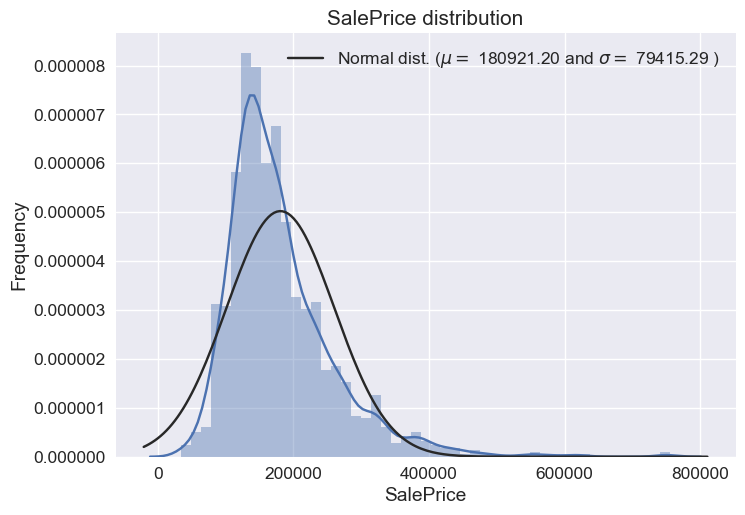

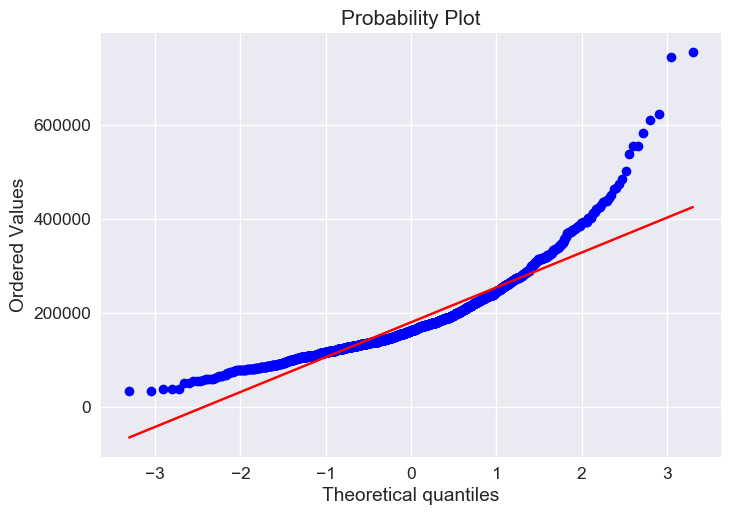

In [32]:
sns.distplot(data_train['SalePrice'] , fit=stats.norm);

(mu, sigma) = stats.norm.fit(data_train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(data_train['SalePrice'], plot=plt)
plt.show()

So SalePrice is positively skewed.to remove Skewness we can use Log-transformation

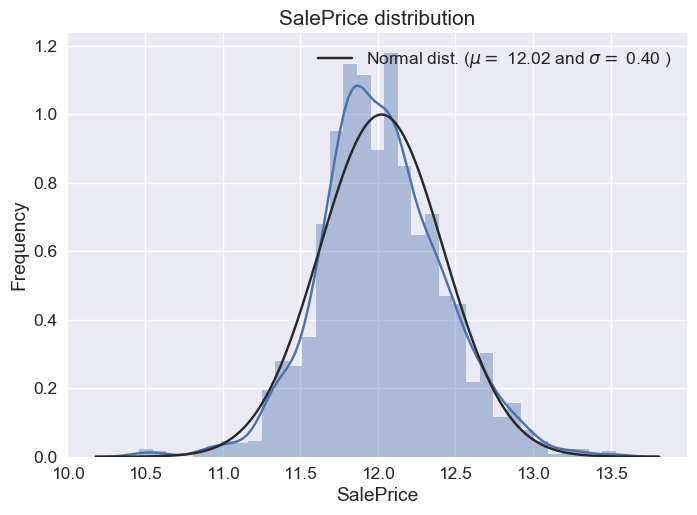

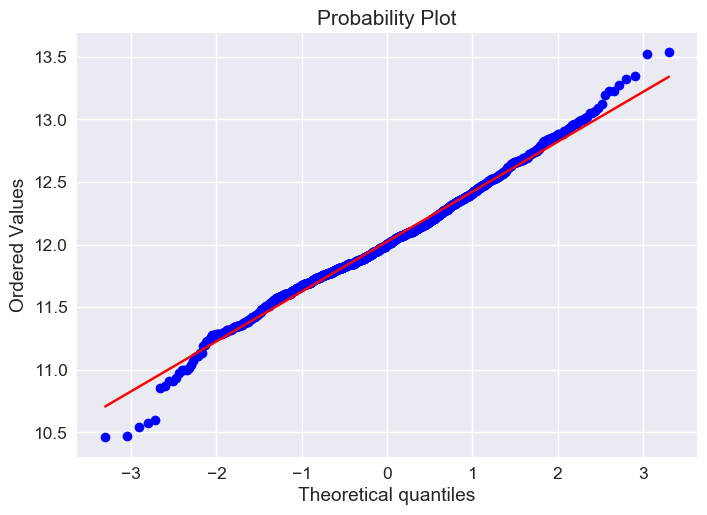

In [33]:
data_train["SalePrice"] = np.log1p(data_train["SalePrice"])
sns.distplot(data_train['SalePrice'] , fit=stats.norm);

(mu, sigma) = stats.norm.fit(data_train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(data_train['SalePrice'], plot=plt)
plt.show()

let's merge test and train dataset for filling missing value. We merge the sets because both of the dataset need same treatment and it's time consuming to do it twice. Also, another key factor is that, from the domain knowledge, we can see that there are different types of feature values in train and test datasets. So if we do not merge them for one-hot encoding, the sizes will not match and show an error. Therefore, we merge the dataset, then preprosess it. Then we split it again.

In [34]:
ntrain = data_train.shape[0]
ntest = data_test.shape[0]
y_train = data_train.SalePrice.values
all_data = pd.concat((data_train, data_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [35]:
all_data.isnull().values.any()

True

So there are some missing values in the dataframe.<br>
check how many data is missing.

In [36]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


Handelling missing data....

In [37]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

all_data = all_data.drop(['Utilities'], axis=1)

In [38]:
all_data.isnull().values.any()

False

Now there is no missing data. Now to modify the subclasses, we at first convert them to strings, then we convert them using label-encoding

In [39]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [40]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 78)


In [41]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

As we see before, our SalePrice is skewed. So there may be other features who are also skewed.So find them and handle them.

In [42]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
#Skewness is a term in statistics used to describes asymmetry from the normal distribution
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


In [43]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [44]:
all_data = pd.get_dummies(all_data)

Now that the majority of the dataset is preprosessed, let's split them like we previously discussed

In [45]:
train = all_data[:ntrain]
test = all_data[ntrain:]

Now using isolation forest we will remove the outliers.

In [46]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

outliers_dataframe = y_noano[y_noano['Top'] == -1]

print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 146
Number of rows without outliers: 1314


In [47]:
outliers_index = []
for index, row in outliers_dataframe.iterrows():
    outliers_index.append(index)

In [48]:
y_train = np.delete(y_train, outliers_index)

In [49]:
len(y_train)

1314

Now we're finally done with the data preprosessing, we'll be using different algorithms once again

In [50]:
regrf_oneHot = RandomForestRegressor(n_estimators = 1000,max_depth = 50,min_samples_split = 10,random_state=5)
regrf_oneHot_cv_score = cross_val_score_calculation(regrf_oneHot,train,y_train)

[ 0.86216892  0.8888179   0.84734542  0.88304395  0.8685641 ]
0.869988056772


In [51]:
print(regrf_oneHot_cv_score)

0.869988056772


In [52]:
regrf_oneHot.fit(train,y_train)
regrf_oneHot_pred = np.expm1(regrf_oneHot.predict(test))

In [53]:
create_result_csv(regrf_oneHot_pred,ids)

This model give me **0.14367** mean square in kaggle

In [54]:
regrMLP_oneHot = MLPRegressor(hidden_layer_sizes=(2500),activation='logistic', solver='lbfgs' )
regrMLP_oneHot_cv_score = cross_val_score_calculation(regrMLP_oneHot,train,y_train)

[ 0.91168857  0.90387856  0.88236116  0.9116478   0.89613417]
0.901142052621


In [55]:
regrMLP_oneHot.fit(train,y_train)
regrMLP_oneHot_pred = np.expm1(regrMLP_oneHot.predict(test))

In [56]:
create_result_csv(regrMLP_oneHot_pred,ids)

This model give me **0.12495** mean square in kaggle

In [57]:
lasso_oneHot = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
rmse= np.sqrt(-cross_val_score(lasso_oneHot, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
rmse.mean()

0.10315552335617009

In [58]:
lasso_oneHot.fit(train,y_train)
lasso_pred_train = lasso_oneHot.predict(train)
lasso_oneHot_cv_score = np.sqrt(mean_squared_error(y_train, lasso_pred_train))
lasso_oneHot_cv_score = 1 - lasso_oneHot_cv_score
lasso_oneHot_cv_score

0.90689650248410403

In [59]:
lasso_oneHot_pred = np.expm1(lasso_oneHot.predict(test))

In [60]:
create_result_csv(lasso_oneHot_pred,ids)

This model give me **0.11732** mean square in kaggle. 

Again normalizing data may increase score.

In [61]:
normalize_train = normalize_data(train)

(1314, 221)


In [62]:
normalize_test = normalize_data(test)

(1459, 221)


In [63]:
regrf_oneHot_normalize_cv_score = cross_val_score_calculation(regrf_oneHot,normalize_train,y_train)

[ 0.86223358  0.88891669  0.84742385  0.88274695  0.8688942 ]
0.870043052011


In [64]:
regrf_oneHot.fit(train,y_train)
mlp_oneHot_norm_pred = np.expm1(regrf_oneHot.predict(test))

In [65]:
create_result_csv(mlp_oneHot_norm_pred,ids)

This model give me **0.12659** mean square in kaggle

SO normalizing data did not increase my score.

In [66]:
regrf_oneHot_pred

array([ 125715.51664244,  157417.97452686,  179189.38298022, ...,
        155943.03233227,  111483.09278792,  229196.37487495])

In [67]:
regrMLP_oneHot_pred

array([ 118956.68388976,  162949.6694856 ,  184889.37929344, ...,
        174712.49390789,  118280.35780723,  216328.40168469])

In [68]:
lasso_oneHot_pred

array([ 122092.69683614,  163985.80177989,  184484.3389577 , ...,
        172036.08794171,  119750.25130428,  224402.62144586])

let's now check each individual score with respect to one another

In [72]:
print(regrf_corelation_cv_score)
print(regrMLP_corelation_cv_score)
print(regrf_corelation_normalize_cv_score)
print(regrMLP_corelation_normalize_cv_score)
print(regrf_oneHot_cv_score)
print(regrMLP_oneHot_cv_score)
print(lasso_oneHot_cv_score)
print(regrf_oneHot_normalize_cv_score)

0.838880636739
0.667520337579
0.841553071897
0.855526578192
0.869988056772
0.901142052621
0.906896502484
0.870043052011


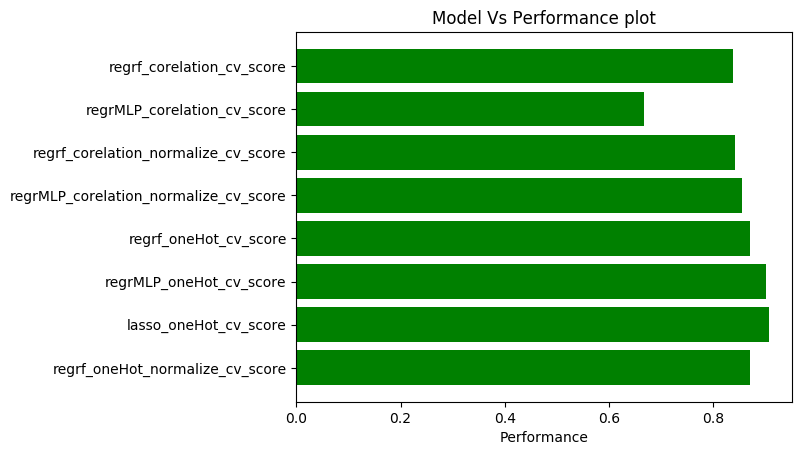

In [76]:
plt.rcdefaults()
fig, ax = plt.subplots()


# Example data
people = ['regrf_corelation_cv_score','regrMLP_corelation_cv_score','regrf_corelation_normalize_cv_score',
          'regrMLP_corelation_normalize_cv_score','regrf_oneHot_cv_score','regrMLP_oneHot_cv_score',
          'lasso_oneHot_cv_score','regrf_oneHot_normalize_cv_score']
y_pos = np.arange(len(people))
performance = [regrf_corelation_cv_score,regrMLP_corelation_cv_score,
                regrf_corelation_normalize_cv_score,regrMLP_corelation_normalize_cv_score,
                regrf_oneHot_cv_score,regrMLP_oneHot_cv_score,lasso_oneHot_cv_score,regrf_oneHot_normalize_cv_score]
error = np.random.rand(len(people))

ax.barh(y_pos, performance,color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Model Vs Performance plot')

plt.show()

<h1>Conclusion</h1>

From the assesment above, we can conclusively say that with the tuning of the parameters the way it was done, Lasso has the best accuarcy with MLPregressor closely following. The Lasso algorithm also works faster than the MLPregressor (ANN). However since the criteria was ANN, I've submitted the ANN score to kaggle and my score was **0.12495**
<br>
<br>
And my best score in kaggle is ** 0.11732** using **Lasso**

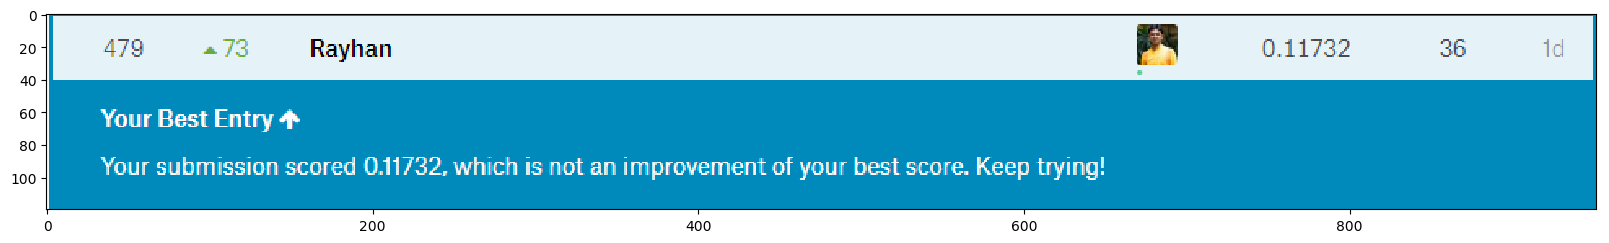

In [82]:
fig = plt.gcf()
fig.set_size_inches(20, 10)
img=mpimg.imread('best_score.png')
imgplot = plt.imshow(img)
plt.show()